In [59]:
import csv
import pandas as pd
import math
import pandas as pd
import cv2
import os
import matplotlib.pyplot as plt
import keras
import numpy as np
import sys 
from sklearn import svm

In [2]:
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input, decode_predictions
from keras.models import Model
from sklearn.datasets import make_multilabel_classification
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import MultiLabelBinarizer
#from keras.applications.imagenet_utils import decode_predictions
#from keras.applications.resnet50 import preprocess_input, decode_predictions

In [3]:
pho_path = './data/train_photos'
bus_path = './data/train.csv'
pho_label = 'photo_tag.csv' 
pho_bus = './data/train_photo_to_biz_ids.csv'

In [4]:
#############read the train business we need for classification
#############we can first get 1500 of them as training set and 500 of them as validation set
bus = pd.read_csv(bus_path)
img_tag = pd.read_csv(pho_label)
img_bus = pd.read_csv(pho_bus)

In [5]:
######separate training and testing set based on the business_id
train = list(bus.head(1500)['business_id'])
test = list(bus.head(500)['business_id'])
total = list(bus['business_id'])
total_label = list(bus['labels'])

In [6]:
test_img = cv2.imread(pho_path+'/'+'52779.jpg')
test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)

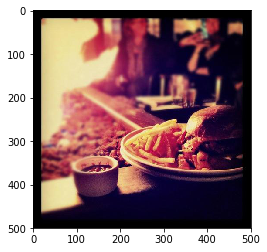

In [7]:
plt.imshow(test_img)
plt.show()

In [62]:
def progressBar(value, endvalue, bar_length=40):
    percent = float(value) / endvalue
    arrow = '-' * int(round(percent * bar_length)-1) + '>'
    spaces = ' ' * (bar_length - len(arrow))

    sys.stdout.write("\rPercent: [{0}] {1}%".format(arrow + spaces, int(round(percent * 100))))
    sys.stdout.flush()

In [63]:
##############this is used to get the feature img from flattern layer based on each business
##############we only collect img_num photos, when the number of photos < img_num, we collect all of them
def collect_map(model_extractfeatures,business_id,img_num):
    #bus_feature = []
    img_list = list(img_bus.loc[img_bus['business_id']==business_id]['photo_id'])
    img_set = []
    if len(img_list)>img_num:
        num = img_num
    else:
        num = len(img_list)
    for img in img_list[:num]:
        test_img = image.load_img(pho_path+'/'+str(img)+'.jpg', target_size=(224,224))
        x = image.img_to_array(test_img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        img_set.append(x)
    img_set = np.array(img_set)
    img_set = np.reshape(img_set,(img_set.shape[0],224,224,3))
    bus_feature = model_extractfeatures.predict(img_set)
    #################return the set of feature and the number of photo for each business
    return bus_feature,len(bus_feature)#np.array(bus_feature)
        

In [64]:
#########the bus_feature should be 2-dimension
#########this is used to reduce the dimension for each image
#########the business here is a set of business, this function will return the reduaction dimension feature for all images
from sklearn.decomposition import PCA
def bus_PCA(business,model_extractfeatures,red_dim,img_num):
    ###########used for count the number od the business to make sure the program work fine
    count = 1
    
    pca = PCA(n_components=red_dim)
    feature_map,num = collect_map(model_extractfeatures,business[0],img_num)
    #print(count)
    progressBar(count,len(business))
    count+=1
    
    #############################
    photo_num = []  ####the number of photos for different business
    photo_num.append(num)
    for b in business[1:]:
        bus_feature,num = collect_map(model_extractfeatures,b,img_num)
        photo_num.append(num)
        feature_map = np.vstack((feature_map,bus_feature))
        #print(count)
        progressBar(count,len(business))
        count+=1
        
    ########now we have all the feature map with size n X 25088, n is the total image numbers 
    if len(feature_map)<red_dim:
        print('There are only {0:10} images, less than {1:10d}'.format(len(feature_map), red_dim))
    pca = pca.fit(feature_map)
    pca_feature = pca.transform(feature_map)
    return pca_feature,photo_num#pca.components_

In [65]:
################used to get the final feature for each business
def get_bus_map(pca_feature):
    return pca_feature.sum(axis=0)/float(pca_feature.shape[0])

In [66]:
############combine the function above to get the final feature for 
def get_total_map(business,model_extractfeatures,red_dim,img_num):
    
    ################get the total set for pca features and number of business photos
    pca_features,bus_pho_num = bus_PCA(business,model_extractfeatures,red_dim,img_num)
    
    ###############get the first feature vector for business
    start = 0
    end = bus_pho_num[0]
    bus_feature_map = get_bus_map(pca_features[start:end])
    start = end
    
    for num in bus_pho_num[1:]:
        end = start + num
        bus_f_map = get_bus_map(pca_features[start:end])
        start = end
        bus_feature_map = np.vstack((bus_feature_map,bus_f_map))
        
    return np.array(bus_feature_map)

In [67]:
#############one hot here should be multi hot :)
def get_one_hot(total_label):
    labels = []
    for t_l in total_label:
        l = [0 for i in range(9)]
        for t in t_l.split(' '):
            #print(t)
            l[int(t)]=1
        labels.append(l)
    return np.array(labels)

In [87]:
def F1_score(test_y,predict_y):
    tp = (test_y*predict_y).sum(axis=1)
    fp=[]
    fn=[]
    for t_y,p_y in zip(test_y,predict_y):
        false_p = 0
        false_n = 0
        for t,p in zip(t_y,p_y):
            if t==0 and p==1:
                false_p+=1.
            if t==1 and p==0:
                false_n+=1.
        fp.append(false_p)  
        fn.append(false_n) 
    fp = np.array(fp)
    fn = np.array(fn)
    #print(tp,fp,fn)
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    #print(p,r)
    F1 = []
    for p,r in zip(precision,recall):
        if p==0 and r==0:
            F1.append(0)
        else:
            F1.append(2*(p*r)/(p+r))
    #print(F1)
    F1 = np.array(F1)
    F1 = F1.sum()/len(F1)
    return F1

In [70]:
###########train_num is the number of business we want to choose from business_id
###########test_num is number we want to choose from the test_business_id, train_num+test_num should less than 2000
###########red_dim is the dimension we want the PCA to get, 
###########img_num is the number we want at most from each business


def train(train_num,test_num,model_extractfeatures,red_dim,img_num):
    ##############the feature map should be (n,128) n here is 2000
    print('Begin feature extracting')
    feature_map = get_total_map(total[:train_num],model_extractfeatures,red_dim,img_num)
    train_label = get_one_hot(total_label[:train_num])
    print('Finish feature extracting')
    
    print('Begin training')
    ##############training part
    classifier = OneVsRestClassifier(svm.SVC(kernel='linear', probability=True))
    classifier.fit(feature_map,train_label)
    print('Finish training')
    
    print('Begin Predicting')
    ##############prediction part
    test_x = get_total_map(total[train_num:train_num+test_num],model_extractfeatures,red_dim,img_num)
    pred_y = classifier.predict(test_x)
    print('Finish predicting')
    
    test_y = get_one_hot(total_label[train_num:train_num+test_num])
    
    ##############evaluation
    F1 = F1_score(test_y,pred_y)
    return F1,pred_y,test_y

In [71]:
##################here we use 100 train_business_id and 20 test_business_id
train_num = 100
test_num =50
red_dim = 400
img_num = 800

vgg = VGG16(weights='imagenet')
model_extractfeatures = Model(input=vgg.input, output=vgg.get_layer('flatten').output)

##################we set 300 as the features for each business, for eaach business we take at most 800 images
F1,pred_y,test_y = train(train_num,test_num,model_extractfeatures,red_dim,img_num)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("fl...)`
  


Begin feature extracting
Percent: [--------------------------------------->] 99%Finish feature extracting
Begin training
Finish training
Finish training
Percent: [--------------------------------------> ] 98%Finish predictiong
(50,) (50,) (50,)


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in true_divide


In [88]:
F1_score(test_y,pred_y)

0.5727200577200577

In [89]:
##################check corresponding image for the label we predict
for b_id in total[train_num:train_num+test_num]:
    img_list = list(img_bus.loc[img_bus['business_id']==b_id]['photo_id'])
    print('b_id is {0:1d}, number of photos is {1:1d}'.format(b_id,len(img_list)))

b_id is 1165, number of photos is 94
b_id is 1166, number of photos is 5
b_id is 1167, number of photos is 60
b_id is 1168, number of photos is 86
b_id is 1169, number of photos is 44
b_id is 1171, number of photos is 50
b_id is 1172, number of photos is 141
b_id is 1175, number of photos is 361
b_id is 1176, number of photos is 24
b_id is 1177, number of photos is 362
b_id is 1179, number of photos is 93
b_id is 1180, number of photos is 181
b_id is 1181, number of photos is 30
b_id is 118, number of photos is 266
b_id is 1184, number of photos is 14
b_id is 1185, number of photos is 559
b_id is 1188, number of photos is 45
b_id is 1189, number of photos is 213
b_id is 1190, number of photos is 42
b_id is 119, number of photos is 260
b_id is 1193, number of photos is 351
b_id is 1194, number of photos is 35
b_id is 1198, number of photos is 79
b_id is 1200, number of photos is 72
b_id is 1201, number of photos is 28
b_id is 120, number of photos is 55
b_id is 1202, number of photos is

In [53]:
def plot_img(business_id):
    img_list = list(img_bus.loc[img_bus['business_id']==business_id]['photo_id'])
    for img in img_list:
        test_img = cv2.imread(pho_path+'/'+str(img)+'.jpg')
        test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)
        plt.imshow(test_img)
        plt.show()

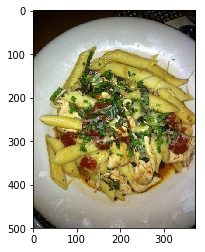

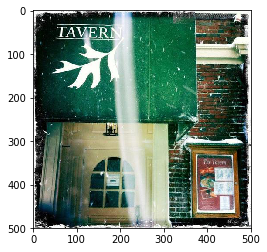

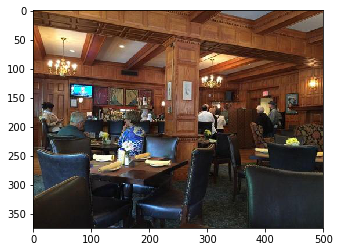

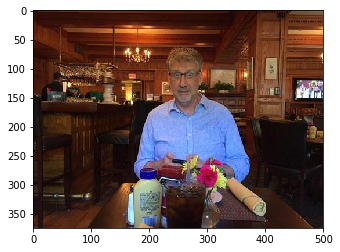

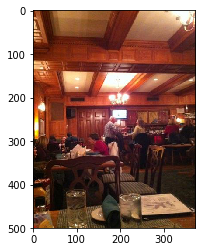

In [54]:
plot_img(1166)

In [90]:
test_y[1],pred_y[1]

(array([1, 0, 1, 0, 0, 1, 1, 1, 0]), array([1, 0, 0, 1, 0, 0, 1, 0, 1]))